<a href="https://colab.research.google.com/github/donguyenquynhnhu/Public/blob/main/DoNguyenQuynhNhu_CNN_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.25MB/s]


Epoch 1, Loss: 0.2904
Epoch 2, Loss: 0.0854
Epoch 3, Loss: 0.0656
Epoch 4, Loss: 0.0554
Epoch 5, Loss: 0.0491


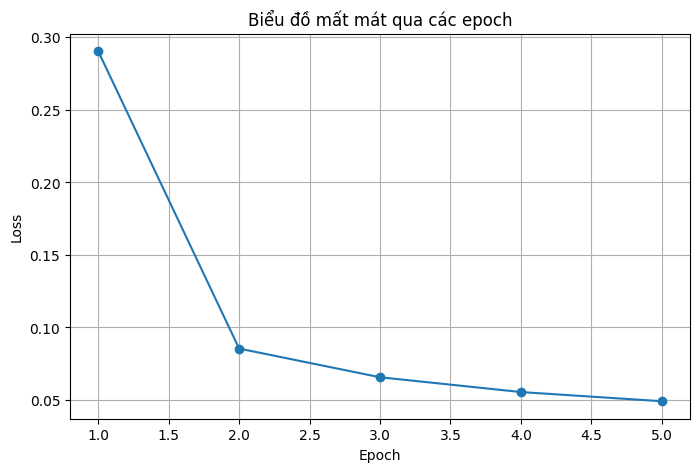

Độ chính xác trên tập test: 98.56%


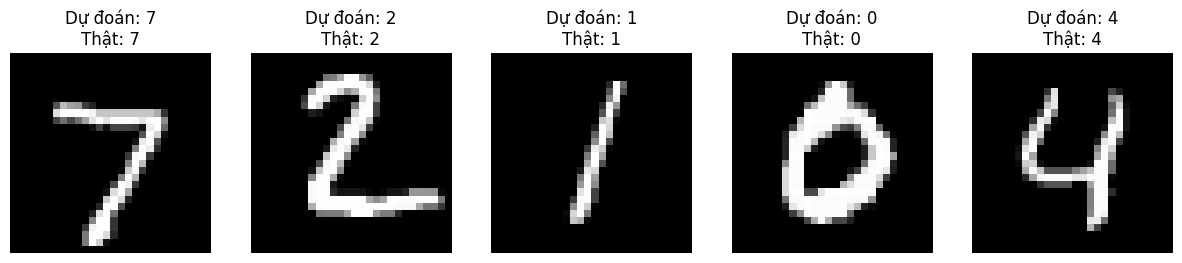

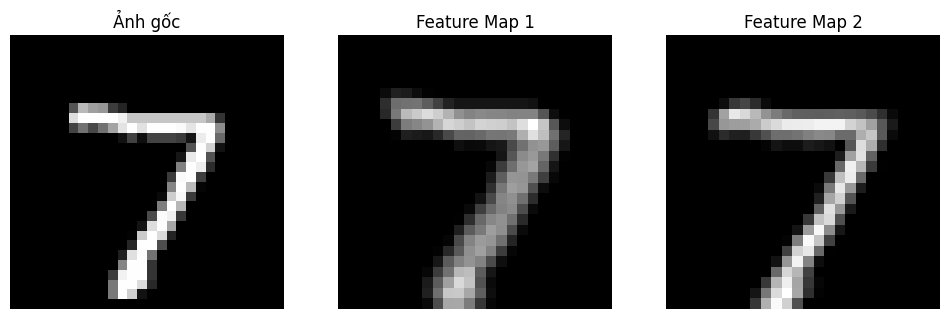

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Tải dữ liệu MNIST
transform = transforms.ToTensor()  # Chuyển ảnh thành tensor
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# 2. Định nghĩa mô hình CNN
class MNIST_CNN(nn.Module):  # Tạo lớp MNIST_CNN kế thừa từ nn.Module (lớp cơ bản của PyTorch)
    def __init__(self):  # Hàm khởi tạo mô hình
        super(MNIST_CNN, self).__init__()  # Gọi hàm khởi tạo của lớp cha (nn.Module)
        # Tầng tích chập 1: 1 kênh đầu vào (ảnh đen trắng) -> 16 kênh đầu ra, filter 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)  # Tích chập giảm kích thước từ 28x28 -> 26x26
        # Tầng tích chập 2: 16 kênh đầu vào -> 32 kênh đầu ra, filter 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)  # Tích chập giảm từ 12x12 -> 10x10 (sau pooling)
        # Tầng pooling: vùng 2x2, giảm kích thước một nửa
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Ví dụ: 26x26 -> 13x13, 10x10 -> 5x5
        # Tầng fully connected: từ 32 kênh * 5x5 (800) -> 10 lớp (0-9)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)  # Duỗi feature map thành vector rồi phân loại

    def forward(self, x):  # Hàm forward định nghĩa luồng dữ liệu qua các tầng
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU (loại giá trị âm) -> Pool (giảm kích thước)
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool, cuối cùng ra 32x5x5
        x = x.view(-1, 32 * 5 * 5)  # Duỗi tensor thành vector, -1 tự động tính batch size
        x = self.fc1(x)  # Qua tầng fully connected, ra 10 giá trị (logits cho 0-9)
        return x  # Trả về kết quả dự đoán




# Khởi tạo mô hình
model = MNIST_CNN()  # Tạo một instance của lớp MNIST_CNN
criterion = nn.CrossEntropyLoss()  # Định nghĩa hàm mất mát CrossEntropy (dùng cho phân loại nhiều lớp)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Dùng SGD với learning rate 0.01 và momentum 0.9 để tối ưu


# 3. Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Chọn GPU nếu có, không thì dùng CPU
model.to(device)  # Chuyển mô hình sang thiết bị đã chọn (GPU/CPU)

loss_values = []  # Tạo list để lưu giá trị mất mát trung bình của mỗi epoch
for epoch in range(5): # Lặp qua 5 epoch (mỗi epoch là một lần duyệt hết dữ liệu)
    running_loss = 0.0  # Biến để cộng dồn mất mát trong epoch
    for images, labels in train_loader:  # Lặp qua từng batch trong tập huấn luyện
        images, labels = images.to(device), labels.to(device)  # Chuyển ảnh và nhãn sang GPU/CPU

        optimizer.zero_grad()  # Xóa gradient cũ để tránh tích lũy từ bước trước
        outputs = model(images)  # Đưa ảnh qua mô hình, nhận dự đoán (logits)
        loss = criterion(outputs, labels)  # Tính mất mát giữa dự đoán và nhãn thật
        loss.backward()  # Tính gradient ngược (backpropagation)
        optimizer.step()  # Cập nhật trọng số dựa trên gradient

        running_loss += loss.item()  # Cộng dồn giá trị mất mát của batch
    epoch_loss = running_loss / len(train_loader)  # Tính mất mát trung bình của epoch
    loss_values.append(epoch_loss)  # Lưu mất mát trung bình vào list
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")  # In mất mát trung bình sau mỗi epoch


# Vẽ biểu đồ loss
plt.figure(figsize=(8, 5))  # Tạo khung hình kích thước 8x5
plt.plot(range(1, 6), loss_values, marker='o')  # Vẽ đường mất mát qua 5 epoch, thêm điểm đánh dấu
plt.title("Biểu đồ mất mát qua các epoch")  # Tiêu đề biểu đồ
plt.xlabel("Epoch")  # Nhãn trục x
plt.ylabel("Loss")  # Nhãn trục y
plt.grid(True)  # Thêm lưới để dễ nhìn
plt.show()  # Hiển thị biểu đồ


correct = 0  # Đếm số dự đoán đúng
total = 0  # Đếm tổng số mẫu
with torch.no_grad():  # Tắt tính gradient vì chỉ đánh giá, không huấn luyện
    for images, labels in test_loader:  # Lặp qua từng batch trong tập kiểm tra
        images, labels = images.to(device), labels.to(device)  # Chuyển dữ liệu sang GPU/CPU
        outputs = model(images)  # Dự đoán trên batch ảnh
        _, predicted = torch.max(outputs.data, 1)  # Lấy chỉ số lớp có giá trị lớn nhất (dự đoán)
        total += labels.size(0)  # Cộng số mẫu trong batch vào tổng
        correct += (predicted == labels).sum().item()  # Cộng số dự đoán đúng
print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")  # Tính và in độ chính xác (%)


# Trực quan kết quả dự đoán
def visualize_prediction():  # Hàm để vẽ 5 ảnh và dự đoán
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (tắt dropout, batch norm nếu có)
    images, labels = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra
    images, labels = images.to(device), labels.to(device)  # Chuyển sang GPU/CPU
    outputs = model(images)  # Dự đoán trên batch
    _, predicted = torch.max(outputs, 1)  # Lấy chỉ số lớp dự đoán

    # Vẽ 5 ảnh đầu tiên
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Tạo lưới 1x5 để vẽ 5 ảnh
    for i in range(5):  # Lặp qua 5 ảnh đầu
        axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Vẽ ảnh (chuyển về CPU, bỏ kênh 1)
        axes[i].set_title(f"Dự đoán: {predicted[i].item()}\nThật: {labels[i].item()}")  # Ghi nhãn dự đoán và thật
        axes[i].axis('off')  # Tắt trục tọa độ
    plt.show()  # Hiển thị hình

visualize_prediction()  # Gọi hàm để vẽ


#Trực quan feature map
def visualize_feature_map():  # Hàm để vẽ ảnh gốc và feature map từ tầng conv1
    model.eval()  # Chuyển sang chế độ đánh giá
    images, _ = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra (bỏ nhãn)
    img = images[0].unsqueeze(0).to(device)  # Lấy ảnh đầu tiên, thêm chiều batch (1x1x28x28)

    # Tính feature map từ conv1
    conv1_output = torch.relu(model.conv1(img))  # Qua conv1 và ReLU, ra tensor 1x16x26x26

    # Vẽ ảnh gốc và feature map
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Ảnh gốc")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map đầu tiên
    plt.subplot(1, 3, 2)
    plt.title("Feature Map 1")
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map thứ hai
    plt.subplot(1, 3, 3)
    plt.title("Feature Map 2")
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

visualize_feature_map()




Câu 1: Thay đổi số lượng epoch

Epoch 1, Loss: 0.0451
Epoch 2, Loss: 0.0404
Epoch 3, Loss: 0.0385
Epoch 4, Loss: 0.0353
Epoch 5, Loss: 0.0327
Epoch 6, Loss: 0.0308
Epoch 7, Loss: 0.0296
Epoch 8, Loss: 0.0280
Epoch 9, Loss: 0.0256
Epoch 10, Loss: 0.0252


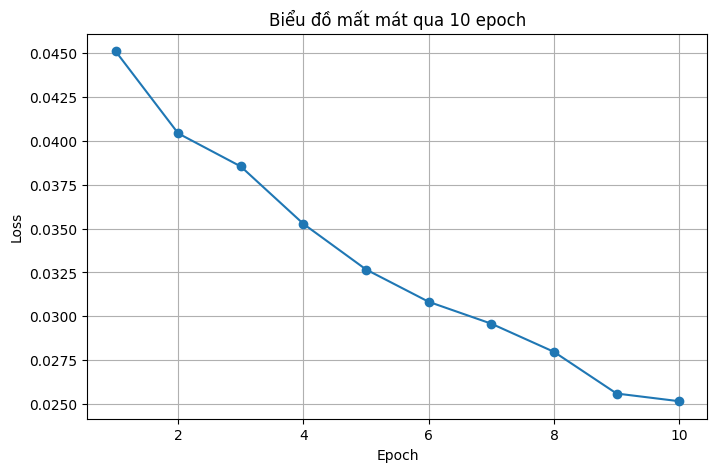

Độ chính xác trên tập test: 98.83%


In [ ]:
# 3. Huấn luyện mô hình (đã sửa epoch từ 5 lên 10)
loss_values = []  # Tạo list để lưu giá trị mất mát trung bình của mỗi epoch
for epoch in range(10):  # Đã thay đổi từ 5 lên 10 epoch
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Vẽ biểu đồ loss (đã cập nhật range từ 6 lên 11)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), loss_values, marker='o')  # Đã thay đổi range(1,6) thành range(1,11)
plt.title("Biểu đồ mất mát qua 10 epoch")  # Đã cập nhật tiêu đề
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Đánh giá độ chính xác (không thay đổi)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")

Câu 2: Thêm một tầng tích chập

In [ ]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)  # Thêm tầng conv3
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 1 * 1, 10)  # Đã sửa từ 32*5*5 thành 64*1*1

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 16x13x13
        x = self.pool(torch.relu(self.conv2(x)))  # 32x5x5
        x = self.pool(torch.relu(self.conv3(x)))  # Thêm tầng conv3 -> 64x1x1
        x = x.view(-1, 64 * 1 * 1)  # Đã sửa từ 32*5*5 thành 64*1*1
        x = self.fc1(x)
        return x

# Khởi tạo lại mô hình với kiến trúc mới
model = MNIST_CNN()
model.to(device)

# Huấn luyện lại với 10 epoch (giữ nguyên phần còn lại)
loss_values = []
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Đánh giá độ chính xác
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Độ chính xác trên tập test (với 3 tầng tích chập): {100 * correct / total:.2f}%")

Epoch 1, Loss: 2.3056
Epoch 2, Loss: 2.3056
Epoch 3, Loss: 2.3056
Epoch 4, Loss: 2.3056
Epoch 5, Loss: 2.3056
Epoch 6, Loss: 2.3056
Epoch 7, Loss: 2.3056
Epoch 8, Loss: 2.3056
Epoch 9, Loss: 2.3056
Epoch 10, Loss: 2.3056
Độ chính xác trên tập test (với 3 tầng tích chập): 13.21%


Câu 3: Thay đổi learning rate


Đang huấn luyện với learning rate = 0.001
Epoch 1, Loss: 1.7877
Epoch 2, Loss: 0.4076
Epoch 3, Loss: 0.2638
Epoch 4, Loss: 0.2118
Epoch 5, Loss: 0.1822
Epoch 6, Loss: 0.1617
Epoch 7, Loss: 0.1441
Epoch 8, Loss: 0.1318
Epoch 9, Loss: 0.1214
Epoch 10, Loss: 0.1126


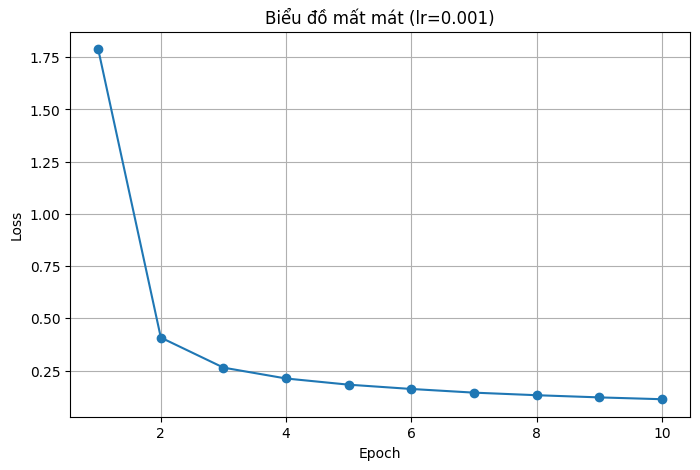

Độ chính xác trên tập test: 96.64%

Đang huấn luyện với learning rate = 0.1
Epoch 1, Loss: 0.2727
Epoch 2, Loss: 0.1095
Epoch 3, Loss: 0.0913
Epoch 4, Loss: 0.0856
Epoch 5, Loss: 0.0722
Epoch 6, Loss: 0.0717
Epoch 7, Loss: 0.0709
Epoch 8, Loss: 0.0773
Epoch 9, Loss: 0.0770
Epoch 10, Loss: 0.0713


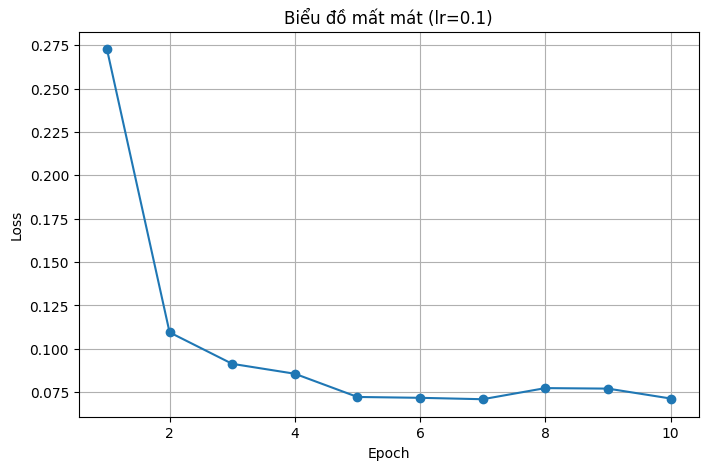

Độ chính xác trên tập test: 97.62%


In [ ]:
# Thử nghiệm với các learning rate khác nhau
learning_rates = [0.001, 0.1]  # Thay đổi từ giá trị ban đầu 0.01

for lr in learning_rates:
    print(f"\nĐang huấn luyện với learning rate = {lr}")
    model = MNIST_CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  # Thay đổi learning rate

    loss_values = []
    for epoch in range(10):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # Vẽ biểu đồ loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), loss_values, marker='o')
    plt.title(f"Biểu đồ mất mát (lr={lr})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # Đánh giá độ chính xác
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")

Câu 4: Vẽ thêm feature map từ tầng tích chập thứ hai


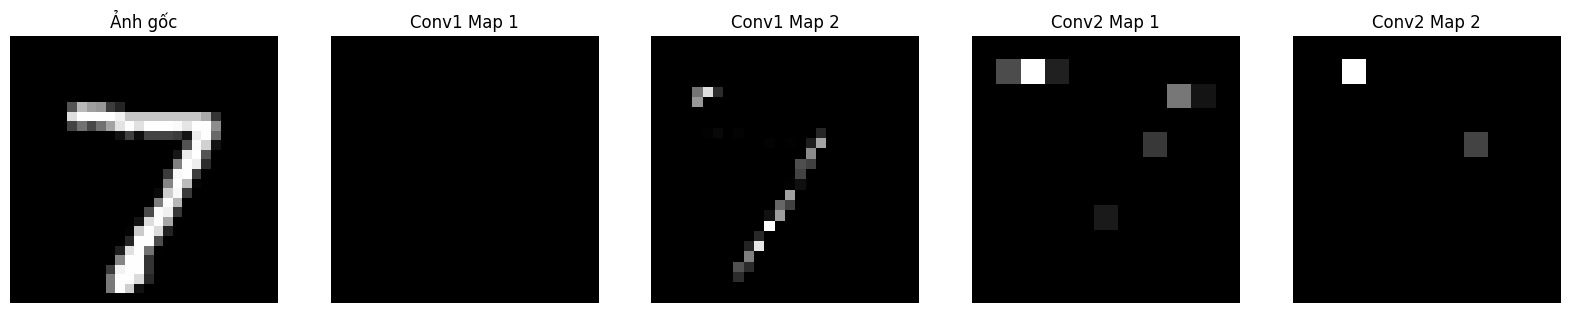

In [ ]:
def visualize_feature_map():  # Hàm để vẽ ảnh gốc và feature map từ tầng conv1 và conv2
    model.eval()  # Chuyển sang chế độ đánh giá
    images, _ = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra (bỏ nhãn)
    img = images[0].unsqueeze(0).to(device)  # Lấy ảnh đầu tiên, thêm chiều batch (1x1x28x28)

    # Tính feature map từ conv1
    conv1_output = torch.relu(model.conv1(img))  # Qua conv1 và ReLU, ra tensor 1x16x26x26

    # Tính feature map từ conv2
    conv2_output = torch.relu(model.conv2(model.pool(conv1_output)))  # Qua pool, conv2 và ReLU

    # Vẽ ảnh gốc và feature maps
    plt.figure(figsize=(20, 4))  # Tăng kích thước khung hình để chứa 5 subplot
    plt.subplot(1, 5, 1)
    plt.title("Ảnh gốc")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map từ conv1
    plt.subplot(1, 5, 2)
    plt.title("Conv1 Map 1")
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title("Conv1 Map 2")
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map từ conv2
    plt.subplot(1, 5, 4)
    plt.title("Conv2 Map 1")
    plt.imshow(conv2_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("Conv2 Map 2")
    plt.imshow(conv2_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.show()

visualize_feature_map()